In [ ]:
# Usual imports
import pandas as pd
import seaborn as sns
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import phik

%matplotlib inline

# if your Jupyter kernel crashes during this code, use this setting
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from fancyimpute import KNN
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

/Users/kirillsobolev/Documents/GitHub/ML_project/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read csv file into dataframe
df = pd.read_csv("../ready_data/merged_starwis_and_weather.csv")

df.head()

,ts,airTemp,humidity,dewpoint,precipitation,Friction,Road_Surface_Temperature,Water_Film_Surface_mm
0,2021-11-01 00:05:00,8.8,94.0,7.9,0,0.82,5.082435,0.0
1,2021-11-01 00:15:00,9.1,91.0,7.7,0,0.82,5.035252,0.0
2,2021-11-01 00:25:00,9.1,90.0,7.5,0,0.82,4.951386,0.0
3,2021-11-01 00:35:00,9.2,88.0,7.3,0,0.82,5.077870,0.0
4,2021-11-01 00:45:00,9.2,86.0,7.0,0,0.82,4.919721,0.0


In [3]:
# No missing values for the merged datasets 
df.isnull().sum()

ts                          0
airTemp                     0
humidity                    0
dewpoint                    0
precipitation               0
Friction                    0
Road_Surface_Temperature    0
Water_Film_Surface_mm       0
dtype: int64

In [4]:
df.duplicated().sum()

0

In [5]:
df = df.drop_duplicates()

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# cale only relevant variables
num_cols = ['airTemp', 'humidity', 'dewpoint', 'Friction',
       'Road_Surface_Temperature', 'Water_Film_Surface_mm']
df[num_cols] = scaler.fit_transform(df[num_cols])
df["ts"] = df.index * 0.1 + 1
df

,ts,airTemp,humidity,dewpoint,precipitation,Friction,Road_Surface_Temperature,Water_Film_Surface_mm
0,1.0,0.820084,0.926829,0.928251,0,1.0,0.612128,0.0
1,1.1,0.826360,0.890244,0.923767,0,1.0,0.611157,0.0
2,1.2,0.826360,0.878049,0.919283,0,1.0,0.609431,0.0
3,1.3,0.828452,0.853659,0.914798,0,1.0,0.612034,0.0
4,1.4,0.828452,0.829268,0.908072,0,1.0,0.608780,0.0
...,...,...,...,...,...,...,...,...
73546,7355.6,0.767782,0.621951,0.773543,0,1.0,0.633253,0.0
73547,7355.7,0.763598,0.634146,0.773543,0,1.0,0.630495,0.0
73548,7355.8,0.753138,0.670732,0.775785,0,1.0,0.625645,0.0
73549,7355.9,0.744770,0.695122,0.773543,0,1.0,0.621283,0.0


In [7]:
df.columns

Index(['ts', 'airTemp', 'humidity', 'dewpoint', 'precipitation', 'Friction',
       'Road_Surface_Temperature', 'Water_Film_Surface_mm'],
      dtype='object')

In [8]:
value_column = ["Friction"]
features = ['ts', 'airTemp', 'humidity', 'dewpoint', 'precipitation',
       'Road_Surface_Temperature', 'Water_Film_Surface_mm']


In [9]:
cutoff = int(len(df) * 0.8)

# train data
X_train = df[features].iloc[0:cutoff]
y_train = df[value_column].iloc[0:cutoff]

# test data 
X_test = df[features].iloc[cutoff:]
y_test = df[value_column].iloc[cutoff:]

# convert everything into NumPy -array format
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# number of variables is just 1 (the scaled passengers value)
n_features = len(features)

# use reshape tools to get the data ready for future use
train_data = X_train.reshape((len(X_train), n_features))
train_series = y_train.reshape((len(y_train), 1))
test_data = X_test.reshape((len(X_test), n_features))
test_series  = y_test.reshape((len(y_test), 1))

In [10]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(58840, 7) (58840, 1)
(14711, 7) (14711, 1)


In [11]:
print(y_test.shape)

(14711, 1)


In [12]:
# the variable that determines how many points 
# back into the past the model attempts to learn
look_back  = 144


batch_size = 64

# using 1 => using time steps
# anything over 1 => uses windowing
window_size = 12

# create a separate generator training and testing data
train_generator = TimeseriesGenerator(X_train, y_train,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = window_size,
                                      batch_size    = batch_size)

test_generator = TimeseriesGenerator(X_test, y_test,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = window_size,
                                      batch_size    = batch_size)

In [13]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Define model
model = Sequential()
model.add(LSTM(64, activation="relu", input_shape=(look_back, n_features), return_sequences=True))
model.add(LSTM(32, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(1))

# Compile with optimized settings
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='mse')

# Callbacks
mc = ModelCheckpoint('best_model_friction.keras', monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
callback_list = [mc, es]

# Fit model with validation generator
model.fit(train_generator, epochs=150, verbose=1, validation_data=test_generator, callbacks=callback_list)

Epoch 1/150
77/77 [==============================] - 6s 74ms/step - loss: nan - val_loss: nan
Epoch 2/150
77/77 [==============================] - 6s 72ms/step - loss: nan - val_loss: nan
Epoch 3/150
77/77 [==============================] - 6s 72ms/step - loss: nan - val_loss: nan
Epoch 4/150
77/77 [==============================] - 6s 73ms/step - loss: nan - val_loss: nan
Epoch 5/150
77/77 [==============================] - 6s 73ms/step - loss: nan - val_loss: nan
Epoch 6/150
77/77 [==============================] - 6s 74ms/step - loss: nan - val_loss: nan
Epoch 7/150
77/77 [==============================] - 6s 73ms/step - loss: nan - val_loss: nan
Epoch 8/150
77/77 [==============================] - 6s 73ms/step - loss: nan - val_loss: nan
Epoch 9/150
77/77 [==============================] - 6s 73ms/step - loss: nan - val_loss: nan
Epoch 10/150
77/77 [==============================] - 6s 74ms/step - loss: nan - val_loss: nan


<Axes: >

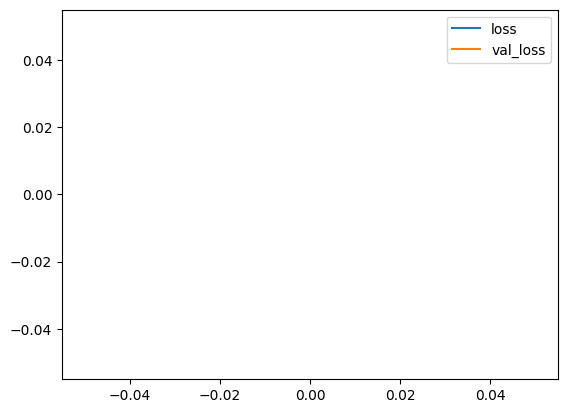

In [14]:
# the usual training metric visualization
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [15]:
# reload the best version of the model
from keras.models import load_model
model = load_model('best_model_friction.keras')

In [16]:
test_predictions = model.predict(test_generator)

19/19 [==============================] - 0s 9ms/step


In [17]:
# TensorFlow evaluation metrics
result = model.evaluate(train_generator)
print(f"Training loss: {result}")

# test loss
result = model.evaluate(test_generator)
print(f"Testing loss: {result}")

77/77 [==============================] - 1s 9ms/step - loss: inf
Training loss: inf
19/19 [==============================] - 0s 9ms/step - loss: 0.1437
Testing loss: 0.1436954289674759


In [18]:
# MAPE score => less than 5% => very excellent result
# MAPE score => less than 10% => excellent result
# MAPE score => 10-20% => good result
# MAPE score => 20-50% => okay / reasonable / decent result

# negative MAPE score => the model constantly overestimates the values
# MAPE score over 100% => the model constantly underestimates the values

In [19]:
# let's make a separate copy of the test values
# so we can calculate some errors

actual_y_test = np.concatenate([y for x, y in test_generator])
errors = np.abs(actual_y_test - test_predictions)
mape = np.mean(errors / actual_y_test) * 100

# print out the MAPE-score
print("MAPE (mean average precision error):")
print(f"{round(mape, 2)} %")

# MAPE results sometimes produce weird results with synthetic data
# since synthetic data is often extremely predictable
# MAE - Mean average error
print("\nMAE")
print(round(metrics.mean_absolute_error(actual_y_test, test_predictions), 2), "units")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(actual_y_test, test_predictions), 2), "units^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(actual_y_test, test_predictions)), 2), "units")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(actual_y_test, test_predictions), 2))

MAPE (mean average precision error):
263.66 %

MAE
0.33 units

MSE
0.14 units^2

RMSE:
0.38 units

R-squared:
-1.88


In [20]:
print(X_test.shape)  # Should be (samples, look_back, n_features)

(14711, 7)


In [21]:
extrapolation = []

# Seed batch from feature set
seed_batch = X_test[:look_back].reshape((1, look_back, n_features))
current_batch = seed_batch

# Extrapolate the next 180 values
for _ in range(180):
    # Predict the next value
    next_value = model.predict(current_batch)[0]
    
    # Append prediction to extrapolation list
    extrapolation.append(next_value)
    
    # Update the current batch (sliding window)
    current_batch = np.append(current_batch[:, 1:, :], [[next_value]], axis=1)

# Convert extrapolation to desired format if needed

ValueError: in user code:

    File "/Users/kirillsobolev/Documents/GitHub/ML_project/.venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/Users/kirillsobolev/Documents/GitHub/ML_project/.venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/kirillsobolev/Documents/GitHub/ML_project/.venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/kirillsobolev/Documents/GitHub/ML_project/.venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/Users/kirillsobolev/Documents/GitHub/ML_project/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/kirillsobolev/Documents/GitHub/ML_project/.venv/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 36, 7), found shape=(None, 144, 7)


In [ ]:
extrapolation = list()
seed_batch    = X_test[:look_back].reshape((1, look_back, n_features))
current_batch = seed_batch

# extrapolate the next 180 values
for i in range(12):
    predicted_value = model.predict(current_batch, verbose=None)[0]
    extrapolation.append(predicted_value) 
    current_batch = np.append(current_batch[:,1:,:],[[predicted_value]],axis=1)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 7 and the array at index 1 has size 1

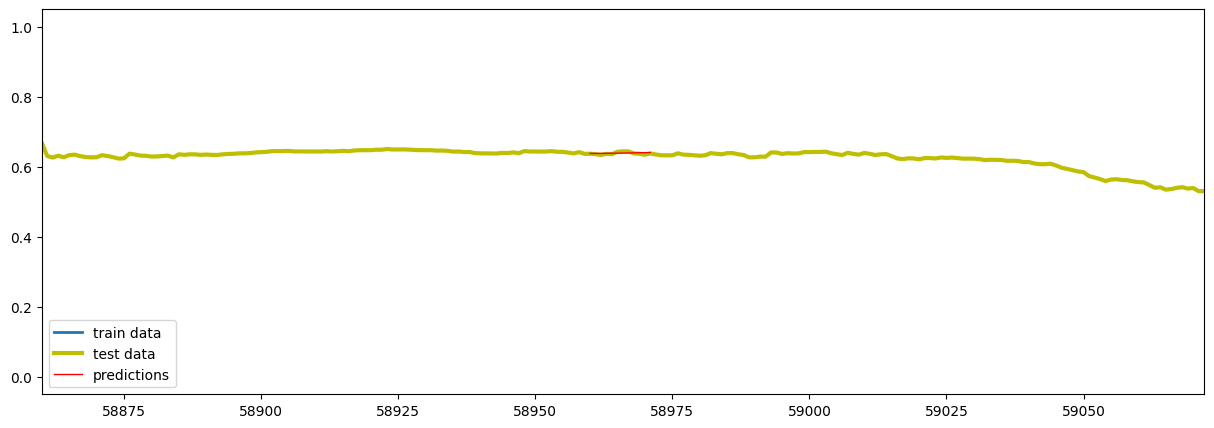

In [ ]:
x1 = np.arange(0, len(y_train))
x2 = np.arange(len(y_train), len(y_train) + len(y_test))
x3 = np.arange(len(y_train) + look_back, len(y_train) + len(extrapolation) + look_back)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x1, y_train, lw=2, label='train data')
ax.plot(x2, y_test, lw=3, c='y', label='test data')
ax.plot(x3, extrapolation, lw=1, c='r', label='predictions')
ax.legend(loc="lower left")

zoom_start = len(y_train) + look_back - 100  # Start a bit before the extrapolation
zoom_end = len(y_train) + len(extrapolation) + look_back + 100  # End a bit after
ax.set_xlim(zoom_start, zoom_end)

plt.show()